In [128]:
using CSV
using DataFrames
using Revise
using StatsBase
using StochasticPrograms
using Gurobi
using JuMP
using StatsPlots
using Distributions
#cd("/Users/frankiecho/Library/CloudStorage/OneDrive-TheUniversityofQueensland/Documents/GitHub/koala-uncertainty/")
cd(raw"C:\Users\uqfcho\OneDrive - The University of Queensland\Documents\GitHub\koala-uncertainty")

include("optim-functions.jl")

fcn_evaluate_solution (generic function with 1 method)

In [16]:
cost_df = CSV.read("data/spatial_predictions_10yr.csv", DataFrame);
kitl_index_full = CSV.read("data/kitl_prop_climate.csv", DataFrame);
stratified_samples = CSV.read("data/stratified_sample.csv", DataFrame);
climateProjList = ["CCCMA_R1", "CCCMA_R2", "CCCMA_R3", "CSIRO_R1", "CSIRO_R2", "CSIRO_R3", "ECHAM_R1", "ECHAM_R2", "ECHAM_R3", "MIROC_R1", "MIROC_R2", "MIROC_R3"];

Calculate opportunity costs given an inflation rate

In [17]:
inflation_rate = 0.02;
t = 1:60;

function cost_to_ts(cost, area, adopt, idx_before=1:3, idx_after=4:6, inflation_rate = 0.02)
  tp = 1:6 # time periods
  t_blocks = [(1:10) .+ (td-1)*10 for td in tp];
  delta = (1+inflation_rate).^(t);
  cost_ts = (cost .* 1000 .* area .* adopt ./ 10); # Cost per-year
  cost_ts_full = [cost_ts .* d for d in delta];
  cost_delta = mapreduce(permutedims, vcat, cost_ts_full)';
  cost_blocks = mapreduce(permutedims, vcat, [sum(cost_delta[:,td], dims = 2) for td in t_blocks])';
  cost_before = sum(cost_blocks[:, idx_before], dims=2); # Cost start at 2020
  cost_after = sum(cost_blocks[:, idx_after], dims=2);
  return(cost_before, cost_after)
end

adoption = innerjoin(cost_df[:, [:NewPropID, :MeanWTA, :SDWTA, :MeanAdopt, :SDAdopt, :MeanProp, :SDProp, :AREA]], kitl_index_full[cmp.(kitl_index_full.climate_model,"Avg").==0, [:NewPropID]], on = :NewPropID);
cost_before, cost_after = cost_to_ts(adoption.MeanWTA, adoption.AREA, adoption.MeanAdopt)

([25815.051874207988; 19811.55790732091; … ; 10868.211392272427; 10733.907768284918;;], [46760.393256575655; 35885.894914560144; … ; 19686.26060387671; 19442.988178779877;;])

In [18]:
kitl_threshold = 0.25; # cut-off for habitats deemed "high-quality"
ii = 1; # Stratified sample to use
kitl_index = innerjoin(kitl_index_full, adoption[:, [:NewPropID, :AREA, :MeanProp, :MeanAdopt]], on = :NewPropID);

In [19]:

t_symbols = [:t0, :t1, :t2, :t3, :t4, :t5, :t6, :t7]
tt = 4 # Time period when uncertainty is revealed

4

In [20]:
kitl_threshold_values = (kitl_index[:, t_symbols] .+ 0.5) .* kitl_index.AREA .* kitl_index.MeanProp;

Subset dataset to only stratified sampled cells

In [21]:
stratified_df = DataFrame(NewPropID = vec(stratified_samples[:, ii]))
cost_inputs = DataFrame(NewPropID = adoption.NewPropID, cost_before = vec(cost_before), cost_after = vec(cost_after));
cost_subset = innerjoin(stratified_df, cost_inputs, on = :NewPropID);
metric_inputs = DataFrame(NewPropID = kitl_index.NewPropID, climate_model = kitl_index.climate_model);
metric_inputs = hcat(metric_inputs, kitl_threshold_values);
metric_subset = innerjoin(stratified_df, metric_inputs, on = :NewPropID);
filter!(row -> cmp(row.climate_model, "Avg") != 0, metric_subset);
filter!(row -> row.NewPropID ∈ cost_subset.NewPropID, metric_subset);
filter!(row -> row.NewPropID ∈ metric_subset.NewPropID, cost_subset);

In [22]:
climateProjList = ["CCCMA_R1", "CCCMA_R2", "CCCMA_R3", "CSIRO_R1", "CSIRO_R2", "CSIRO_R3", "ECHAM_R1", "ECHAM_R2", "ECHAM_R3", "MIROC_R1", "MIROC_R2", "MIROC_R3"];
metric_subset
CSV.write("data/metric_subset.csv", metric_subset)

"data/metric_subset.csv"

In [23]:
tt

4

In [25]:
N = length(unique(metric_subset.NewPropID))
S = length(climateProjList)
M₁ = zeros(N, length(1:(tt-1)), S)
M₂ = zeros(N, length(tt:length(t_symbols)), S)
for t=1:length(t_symbols)
  for s=1:S
    metric_unstacked = unstack(metric_subset, :NewPropID, :climate_model, t_symbols[t])
    if (t < tt)
      M₁[:,t,:] = Matrix(metric_unstacked[:, climateProjList])
    else
      M₂[:,t-tt+1,:] = Matrix(metric_unstacked[:, climateProjList])
    end
  end
end

In [26]:
r = Realisation(cost_subset.cost_before, cost_subset.cost_after, M₁, M₂)

Realisation([12432.384199054242, 9874.475325585636, 12056.32175033267, 133523.5588664438, 140181.62088322485, 172174.98385832383, 173319.1040696074, 150586.13521790563, 98575.10522015524, 18890.70256603912  …  138562.5829890136, 781776.5238447646, 340520.8282488327, 578458.7222795164, 57029.356948896595, 1.6321440280791444e6, 4.636846715301958e6, 42641.481241635, 165754.5185489979, 11764.13696684975], [22519.543136980406, 17886.245267942286, 21838.358064142318, 241859.4451034392, 253919.60286521405, 311871.1515045831, 313943.5669028983, 272765.94043230754, 178555.1587447353, 34217.892924845924  …  250986.93982043222, 1.4160799626462667e6, 616806.346876992, 1.0477979075266273e6, 103300.786343349, 2.9564029921862693e6, 8.39900601147379e6, 77239.14101036148, 300241.3672912018, 21309.105771881797], [0.9528583023712631 0.7513279267461038 0.7191326699118952; 0.906112065442047 0.5767276008118271 0.5514838844466012; … ; 22.647864163716072 10.968161164922671 10.968161164922671; 1.53636334421944

In [27]:
[sum.(eachcol(M₂[:,:,s])) for s=1:S]

12-element Vector{Vector{Float64}}:
 [287385.3971800607, 278266.3003196805, 269619.59996243706, 262059.35087797587, 255985.44202846126]
 [279578.0825761811, 271570.48017885897, 263998.0891830905, 257320.40535914357, 251833.18617252033]
 [283207.91745669086, 277523.0282164429, 271981.8527398872, 266919.0888236627, 262626.22682727]
 [290409.3395039771, 284905.59255746694, 279184.5140362365, 273859.50279106724, 269051.6794065286]
 [292859.59337934316, 286980.5484465358, 281346.2657746483, 276202.4192896288, 271673.29956002586]
 [289584.0746719709, 285529.50941096677, 281471.0864096532, 277582.5211830083, 273974.06225072924]
 [290179.59314169135, 280205.08648061723, 240710.08001171917, 238841.19772634064, 257009.67226389094]
 [290330.0521879771, 282772.4380735157, 275472.6117483712, 269030.5673790496, 263887.9993910194]
 [285212.48577986285, 277950.36105164106, 271368.7259310348, 265972.69994169223, 261986.42633442488]
 [290464.2492639938, 281302.35578066134, 272730.6699117871, 265566.0468

In [171]:
solution_no_recourse = fcn_two_stage_opt_saa([r], add_recourse = false, terminate_recourse = false)
solution_add_recourse = fcn_two_stage_opt_saa([r], add_recourse = true, terminate_recourse = false)
solution_terminate_recourse = fcn_two_stage_opt_saa([r], add_recourse = false, terminate_recourse = true)
solution_full_recourse = fcn_two_stage_opt_saa([r], add_recourse = true, terminate_recourse = true)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-16
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 6 physical cores, 6 logical processors, using up to 6 threads
Optimize a model with 97 rows, 9538 columns and 925090 nonzeros
Model fingerprint: 0xacc7c283
Coefficient statistics:
  Matrix range     [3e-01, 2e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+03, 7e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1 rows and 1 columns
Presolve time: 0.19s
Presolved: 96 rows, 9537 columns, 915552 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.560e+03
 Factor NZ  : 4.656e+03 (roughly 4 MB of memory)
 Factor Ops : 2.995e+05 (less than 1 second per iteration)
 Threads    : 4

Barrier performed 

(model = A JuMP Model
Minimization problem with:
Variables: 238426
Objective function type: VariableRef
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 114541 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 114444 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 238425 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 238425 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Gurobi
Names registered in the model: w, x, y, z, obj_value = 8.823264558816348e7, x = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], y = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], w = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [38]:
objective_value(solution_no_recourse.model)


1.3069782869306749e8

In [39]:
objective_value(solution_full_recourse.model)

8.823264558816351e7

In [41]:
objective_value(solution_add_recourse.model)

9.079764309146556e7

In [42]:

sum(value.(solution_full_recourse.model[:x]) .- value.(solution_full_recourse.model[:w])[:,10])

36.07878279002094

In [43]:
r.C₁' * value.(solution_full_recourse.model[:x])

3.0161628092569586e7

In [44]:
cost_nr, metric_nr = fcn_evaluate_solution(solution_no_recourse.model, [r])
cost_add, metric_add = fcn_evaluate_solution(solution_add_recourse.model, [r])
cost_terminate, metric_terminate = fcn_evaluate_solution(solution_terminate_recourse.model, [r])
cost_full, metric_full = fcn_evaluate_solution(solution_full_recourse.model, [r])

([8.668415448786359e7; 9.06981694978467e7; … ; 8.509157454779567e7; 8.453114827258633e7;;], [7655.322715887657 7143.731230940931 … 7040.5785490445105 7000.0; 7655.192470887142 7118.662906011406 … 7084.480090789831 6999.999999999998; … ; 7656.247907803548 7192.236456120176 … 7021.345583713232 7000.000000000001; 7656.54193053339 7174.495429383417 … 7024.499567472478 7000.0;;;])

In [45]:
CSV.write("data/habitat_size_add_recourse.csv", DataFrame(metric_add[:,:,1]', climateProjList))
CSV.write("data/habitat_size_no_recourse.csv", DataFrame(metric_nr[:,:,1]', climateProjList))
CSV.write("data/habitat_size_terminate_recourse.csv", DataFrame(metric_terminate[:,:,1]', climateProjList))
CSV.write("data/habitat_size_full_recourse.csv", DataFrame(metric_full[:,:,1]', climateProjList))

CSV.write("data/cost_add_recourse.csv", DataFrame(cost_add', climateProjList))
CSV.write("data/cost_no_recourse.csv", DataFrame(cost_nr', climateProjList))
CSV.write("data/cost_terminate_recourse.csv", DataFrame(cost_terminate', climateProjList))
CSV.write("data/cost_full_recourse.csv", DataFrame(cost_full', climateProjList))

"data/cost_full_recourse.csv"

In [27]:
objective_value(solution_full_recourse.model)

8.823264558816351e7

In [28]:
function fcn_tidy_two_stage_solution(solution, prop_id, climate_models)
  out = hcat(prop_id, solution.x, solution.y, solution.w)
  y_array = ["y_" * c for c in climate_models];
  w_array = ["w_" * c for c in climate_models];
  colnames = vcat(["NewPropID"; "x"], y_array, w_array);
  return DataFrame(out, colnames);
end

function fcn_tidy_two_stage_solution_sum(solution, prop_id)
  out = hcat(prop_id, solution.x, sum(solution.y, dims=2), sum(solution.w, dims=2))
  colnames = vcat(["NewPropID"; "x"; "sum_y"; "sum_w"]);
  return DataFrame(out, colnames);
end

climate_models = climateProjList;
solution_df = map((c->fcn_tidy_two_stage_solution_sum(c, cost_subset.NewPropID)), [solution_no_recourse, solution_add_recourse, solution_terminate_recourse, solution_full_recourse]);

In [29]:
CSV.write("data/solution_no_recourse_kitl.csv", solution_df[1]);
CSV.write("data/solution_add_only_kitl.csv", solution_df[2]);
CSV.write("data/solution_terminate_only_kitl.csv", solution_df[3]);
CSV.write("data/solution_full_recourse_kitl.csv", solution_df[4]);

In [37]:
solution_full_recourse_robust = fcn_two_stage_opt_robust(r, sqrt(2 * log(1 / 0.1))*sqrt(N), add_recourse = true, terminate_recourse = true)

## Evaluate solution on sample
* Variability in WTA
* Adoption
* Proportion

In [48]:
adoption_subset = innerjoin(stratified_df, adoption, on = :NewPropID);
CSV.write("data/adoption_subset.csv", adoption_subset);
nsims = 100;
adopt_binary_sim = [(rand.(Normal.(adoption_subset.MeanAdopt,adoption_subset.SDAdopt))) .> rand(nrow(adoption_subset)) for ns in 1:nsims];
prop_sim = [(rand.(Normal.(adoption_subset.MeanProp,adoption_subset.SDProp)))  for ns in 1:nsims];
cost_sim = [(rand.(Normal.(adoption_subset.MeanWTA, adoption_subset.SDWTA))) for ns in 1:nsims];

In [49]:
cost_before_sim = [adopt_binary_sim[ns] .* cost_to_ts(cost_sim[ns], adoption_subset.AREA, prop_sim[ns])[1] for ns in 1:nsims]
cost_after_sim = [adopt_binary_sim[ns] .* cost_to_ts(cost_sim[ns], adoption_subset.AREA, prop_sim[ns])[2] for ns in 1:nsims]

100-element Vector{Matrix{Float64}}:
 [11158.679205588931; 7667.252859305203; … ; 211328.04224126827; 12383.654387769318;;]
 [11364.150101435422; 7500.2958355974515; … ; 170132.19254146476; 11843.13741104124;;]
 [0.0; 7348.687480714895; … ; 198736.84157195617; 16182.019854700524;;]
 [11053.054556094892; 8500.472162841137; … ; 170925.85482894856; 6136.230169116958;;]
 [0.0; 10119.485258185518; … ; 197947.98935959395; 0.0;;]
 [0.0; 8970.303836794426; … ; 201789.1947994862; 14476.401382591106;;]
 [11391.218126635904; 6502.662694257966; … ; 217909.43186736442; 14844.08382548092;;]
 [0.0; 9564.71437542888; … ; 162255.69778791117; 0.0;;]
 [8547.192175172437; 8741.548707195372; … ; 0.0; 10587.77097305144;;]
 [7533.1128876707535; 8859.990363855331; … ; 203769.81677164536; 0.0;;]
 ⋮
 [8500.766996700933; 10495.6034995165; … ; 190606.21533947834; 13941.281871380605;;]
 [9518.898378207845; 9019.576702428052; … ; 206839.66383807777; 0.0;;]
 [11291.801873214696; 9781.958130449073; … ; 244732.7601970

In [50]:
@define_scenario BehaviourScenario = begin
    C₁::Array{Float64,2}
    C₂::Array{Float64,2}
    M₁::Array{Float64,2}
    M₂::Array{Float64,2}
    @zero begin
        return BehaviourScenario(0.0, 0.0, 0.0, 0.0)
    end
end

@sampler BehaviourSampler = begin
    C₁::Array{Float64,2}
    C₂::Array{Float64,2}
    M₁::Array{Float64,2}
    M₂::Array{Float64,2}

    BehaviourSampler(C₁, C₂, M₁, M₂) = new(C₁, C₂, M₁, M₂)
    @sample BehaviourScenario begin

        MeanAdopt = sampler.Adopt[:,1]
        SDAdopt = sampler.Adopt[:,2]
        MeanProp = sampler.Prop[:,1]
        SDProp = sampler.Prop[:,2]
        MeanWTA = sampler.WTA[:,1]
        SDWTA = sampler.WTA[:,2]
        adopt_binary = (rand.(Normal.(MeanAdopt,SDAdopt))) .> rand(nrow(adoption_subset))
        sample_C₁ = cost_to_ts(MeanWTA + SDWTA .* randn(size(SDWTA)), sampler.Area, MeanProp + SDProp .* randn(size(SDProp)))[1]
        sample_C₂ = cost_to_ts(MeanWTA + SDWTA .* randn(size(SDWTA)), sampler.Area, MeanProp + SDProp .* randn(size(SDProp)))[2]
        
        sample_M₁ = M₁ .* adopt_binary
        sample_M₂ = M₂ .* adopt_binary
        return BehaviourScenario(sample_C₁, sample_C₂, sample_M₁, sample_M₂)
    end
end

In [54]:
realisation_samples = [Realisation(cost_before_sim[ns], cost_after_sim[ns], cat([M₁[:,:,s] .* adopt_binary_sim[ns] for s=1:S]..., dims = 3), cat([M₂[:,:,s] .* adopt_binary_sim[ns] for s=1:S]..., dims = 3)) for ns=1:nsims];

In [55]:
cost_mat, metric_mat = fcn_evaluate_solution(solution_add_recourse.model, realisation_samples)


([6.178617264212445e7 4.685276971993041e7 … 5.318575378638388e7 5.8407567668000415e7; 6.498873236732354e7 4.875533951664068e7 … 5.870920231605443e7 6.181924203934954e7; … ; 6.104107268847009e7 4.610195009588401e7 … 5.2231100990526095e7 5.730041761841893e7; 6.078841517578872e7 4.576425057601604e7 … 5.1915944484127715e7 5.682812002634866e7], [7713.718490505866 6919.938708623638 … 6793.952987414119 6693.916288397448; 7712.823216871121 6838.09688630904 … 6846.820913296299 6708.585613006027; … ; 7714.729255091288 6930.797064400487 … 6764.31890836914 6693.809142621246; 7715.133136738898 6933.803641663338 … 6812.776346221814 6772.527019727096;;; 7571.945992489415 6787.111795309299 … 6614.781274934923 6517.312363377863; 7571.131004238157 6712.397989390573 … 6638.855214910977 6503.057896385935; … ; 7572.909810457488 6794.996496346876 … 6633.074747434453 6567.560368458457; 7573.516511071704 6800.22251906443 … 6689.313745551937 6652.611059761166;;; 7831.201063284582 7032.751896422414 … 6900.02941

In [129]:
#solution_no_recourse_saa = fcn_two_stage_opt_saa(realisation_samples[1:50], add_recourse = false, terminate_recourse = false)
solution_add_recourse_saa = fcn_two_stage_opt_saa(realisation_samples[1:50], add_recourse = true, terminate_recourse = false)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-16
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 6 physical cores, 6 logical processors, using up to 6 threads
Optimize a model with 119245 rows, 123982 columns and 63545818 nonzeros
Model fingerprint: 0x81208fcc
Coefficient statistics:
  Matrix range     [3e-01, 6e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1 rows and 1 columns (presolve time = 6s) ...
Presolve removed 1 rows and 1 columns (presolve time = 23s) ...
Presolve removed 1 rows and 1 columns
Presolve time: 34.35s
Presolved: 119244 rows, 123981 columns, 63421836 nonzeros


Barrier performed 0 iterations in 44.61 seconds (22.50 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 1094 i

(model = A JuMP Model
Minimization problem with:
Variables: 123982
Objective function type: VariableRef
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 4801 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 114444 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 123981 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 123981 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Gurobi
Names registered in the model: x, y, z, obj_value = 6.064889952923146e7, x = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], y = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], w = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [172]:
cost_mat, metric_mat = fcn_evaluate_solution(solution_add_recourse.model, realisation_samples)
cost_mat_saa, metric_mat_saa = fcn_evaluate_solution(solution_add_recourse_saa.model, realisation_samples)


([6.385744762920557e7 4.962261436439528e7 … 6.290664309495097e7 6.768567791556859e7; 6.617867781862189e7 5.164982807609403e7 … 6.535551433943994e7 7.055920755818991e7; … ; 6.317827683286452e7 4.909075688345033e7 … 6.179237937906575e7 6.743239170901152e7; 6.197159347983658e7 4.772393288336633e7 … 6.1198887931419164e7 6.61259360688504e7], [8113.744006539229 7310.1912341083735 … 7181.087601893515 7063.173538475181; 8113.219902060336 7256.579411540999 … 7239.715024897412 7082.56397297184; … ; 8115.107896854084 7359.192734452438 … 7210.86058152165 7103.384465203539; 8115.56048753507 7350.424092542281 … 7166.697333785169 7105.495871350473;;; 8036.607137162799 7222.698436601369 … 7109.10909142494 7000.000000000002; 8036.036858233041 7166.263552256312 … 7144.964778566872 7000.0; … ; 8037.886431952762 7266.849065464194 … 7123.461785049289 7024.822433757617; 8038.465413803886 7262.52886686268 … 7094.754025559239 7037.550405303318;;; 8029.213311863444 7220.661750605737 … 7116.004316531403 7009.87

In [174]:
mean(dropdims(sum(metric_mat_saa .< 6999, dims = (1,2)) .> 0, dims = (1,2)))

0.27

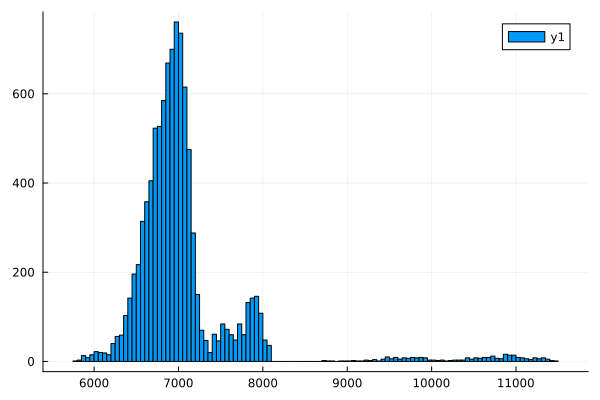

In [175]:
histogram(vec(metric_mat))